# EDA Analysis

## Import Libraries

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler
from sklearn.impute import KNNImputer

## Import Data

In [2]:
train = pd.read_csv('../../datasets/train.csv')
test = pd.read_csv('../../datasets/test.csv')

## Clean Data

### Change Column Names to lower case

In [3]:
train.columns = train.columns.str.lower().str.replace(' ', '_')
test.columns = test.columns.str.lower().str.replace(' ', '_')

### Clean Data Helpers

In [4]:

def consistent(df, col):
    '''
        finds columns that are continous and unique in value
    '''
    for i in range(len(df)):
        if  i == 0:
            first_dtype = type(df.loc[i, col])
        else:
            if first_dtype != type(df.loc[i, col]): # case when not consistent
                return False
    return True

def col_values_info(df, col):
    '''
        function to find typical eda analysis information
    '''
    shape = df.shape
    unique_values = list(df[col].unique())
    na_val = df[col].isna().sum()
    len_list = len(unique_values)
    is_consistent = consistent(df, col)
    data_type = type(df[col].iloc[0])
    values_counts = dict(df[col].value_counts(dropna=False))
    
    info = dict(col_name=col, values_counts=values_counts, num_na=na_val,
                con_dtype = is_consistent, unq_col = (shape[0] == len_list))
    return info

def get_transform_list(df, info):
    '''
        function to get the columns of categorical, columns of missing categorical, columns of numeric, columns of missing numeric, and columns that are continous and unique in value
    '''
    high_card = [key for key, data in info.items() if data['unq_col']]
    
    numeric = [col for col in df.select_dtypes(include=['number']) if col not in high_card + ['saleprice'] ]
    numeric_issue = [col for col in numeric if df[col].isna().sum() != 0]
    numeric = [col for col in numeric if col not in numeric_issue]


    categorical = [col for col in df.select_dtypes(exclude=['number'])]
    categorical_issue = [col for col in categorical if df[col].isna().sum() != 0]
    categorical = [col for col in categorical if col not in categorical_issue]
    
    # print(len(numeric_issue) + len(numeric) + len(categorical_issue) + len(categorical) + len(high_card))
    return high_card, numeric, numeric_issue, categorical, categorical_issue

def rows_to_change(df, col_list):
    '''
        Identifies:
            col with small number of missing rows < 20%
            col with large number of missing rows > 50%
            col with number of missing values in between > 20% and < 50%
    '''
    train_shape = df.shape
    small_m_rows = []
    large_m_rows = []
    other_m_rows = []
    for col in col_list:
        # print(col)
        if df[col].isna().sum() < (train_shape[0]*0.2): # col is missing less then 20% of values
            small_m_rows.append(col)
        elif df[col].isna().sum()  > (train_shape[0]*0.5): # col is missing more then 50% of values
            large_m_rows.append(col)
        else: # col is missing between 20% and 50% 
            other_m_rows.append(col)   
    return small_m_rows, large_m_rows, other_m_rows

def dummy_df():
    '''
        Convert all categorical values in train to a dummy variables
    '''
    u_val_df = train.copy()
    for col in categorical + categorical_issue:
        unique_vals = u_val_df[col].unique()
        u_val_df[col].replace(to_replace=unique_vals,
                   value= list(range(len(unique_vals))),
                   inplace=True)
    return u_val_df

### Understand missing Value Data

In [5]:
train_col_info = {i:col_values_info(train, str(i)) for i in train.columns} # get EDA Info of train
high_card, numeric, numeric_issue, categorical, categorical_issue = get_transform_list(train, train_col_info) # get columns that have issues with data train

test_col_info = {i:col_values_info(test, str(i)) for i in test.columns} # get EDA Info of test
high_card_test, numeric_test, numeric_issue_test_test, categorical_test, categorical_issue_test = get_transform_list(test, test_col_info) # get columns that have issues with data test

train_copy = train.copy() # make a train copy so you dont mess with raw data

In [6]:
categorical_columns = categorical + categorical_issue # all categorical columns train
numeric_columns = numeric + numeric_issue # all numeric columns train

categorical_columns_test = categorical_test + categorical_issue_test # all categorical columns test
numeric_columns_test = numeric_test + numeric_issue_test_test # all numeric columns test

### Categorical Clean

In [7]:
cat_small_m, cat_large_m, cat_other_m = rows_to_change(train, categorical_issue) # get lists of categorical columns that have issues based on how many missing values they have train

In [8]:
# [train_col_info[i] for i in train_col_info if i in cat_small_m]
train_copy[cat_small_m].fillna('None', inplace=True) # replace all missing observations for categorical columns that are missing < 20% train

test[cat_small_m].fillna('None', inplace=True) # replace all missing observations for categorical columns that are missing < 20% test

/Users/robertsarno/Documents/Winter_2021/Projects/Stock_Trading/Stock_Stategy_Bot/SSB/lib/python3.9/site-packages/pandas/core/frame.py:5171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [9]:
# [train_col_info[i] for i in train_col_info if i in cat_large_m]
train_copy[cat_large_m] = train_copy[cat_large_m].fillna('None') # replace all missing observations for categorical columns that are missing > 50% train

test[cat_large_m] = test[cat_large_m].fillna('None') # replace all missing observations for categorical columns that are missing > 50% test

In [10]:
# [train_col_info[i] for i in train_col_info if i in cat_other_m]
train_copy[cat_other_m] = train_copy[cat_other_m].fillna('None') # fixed all missing values for categorical columns that are missing < 50% and <20% train

test[cat_other_m] = test[cat_other_m].fillna('None') # fixed all missing values for categorical columns that are missing < 50% and <20%  test

In [11]:
train_copy[categorical + categorical_issue] = train_copy[categorical + categorical_issue].astype('category') # change type category train

test[categorical + categorical_issue] = test[categorical + categorical_issue].astype('category') # change type category test

In [12]:
u_val_df = dummy_df() # get dummy df of all columns from train

### Numeric Clean

In [13]:
num_small_m, num_large_m, num_other_m = rows_to_change(train, numeric_issue) # get lists of numeric columns that have issues based on how many missing values they have train

In [14]:
train_copy[num_small_m] = train_copy[num_small_m].fillna(0) # replace all missing observations for numeric columns that are missing < 20% train

test[num_small_m] = test[num_small_m].fillna(0) # replace all missing observations for numeric columns that are missing < 20% test

In [15]:
train_copy[numeric + numeric_issue] = train_copy[numeric + numeric_issue].astype(float) # change type float train

test[numeric + numeric_issue] = test[numeric + numeric_issue].astype(float) # change type float test

## Analysis

### HelperFunctions:

In [16]:
def find_high_corr(df, col):
    '''
        Find high corr in a df for a specific col
    '''
    c = df.corr()

    s = c.unstack()
    so = s.sort_values(ascending=False, kind="quicksort")
    corr_list=[]
    for i, j in so.items():
        if (i[0] != i[1]) and ((i, j) not in corr_list and (i[::-1], j) not in corr_list) and (i[0] in [col] or i[1] in [col]) and (j > 0.5) or (j < -0.5):
            corr_list.append((i, j))
    return corr_list

def remove_outliers(df, columns, low=0.01, high=0.99):
    '''
        remove .01 quantile and .99 quantile from data set
    '''
    for col in columns:
        q_low = df[col].quantile(low)
        q_hi  = df[col].quantile(high)
        temp = df[(df[col] < q_hi) & (df[col] > q_low)]
    return df

### Inital Info

In [17]:
# specific year listed that doesnt make any sense in terms of saleprice
train_copy = remove_outliers(train_copy, numeric + numeric_issue)
ohe = OneHotEncoder() # one hot encode categorical columns
ohe.fit(train[categorical_columns])
encoded_col = pd.DataFrame(ohe.transform(train[categorical_columns]).todense(), columns=ohe.get_feature_names(categorical_columns))
train.drop(columns=categorical_columns, axis=1, inplace=True)
ohe_df = pd.concat([train, encoded_col], axis=1)

In [18]:
saleprice_corl = find_high_corr(ohe_df, 'saleprice')

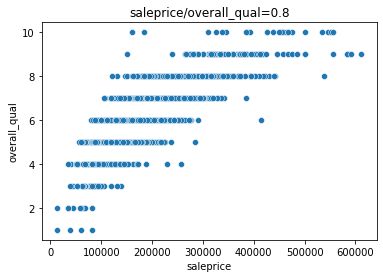

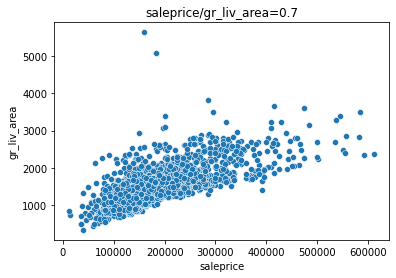

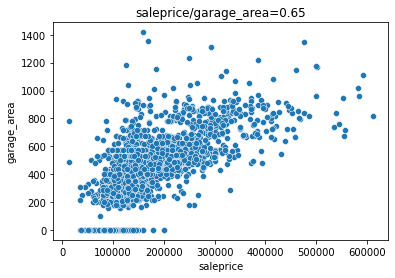

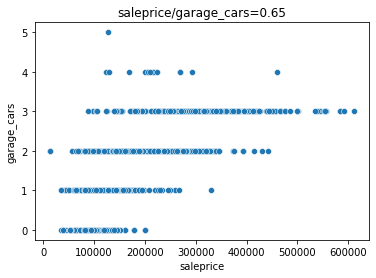

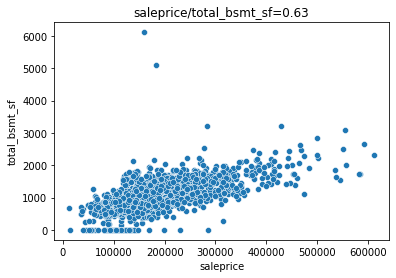

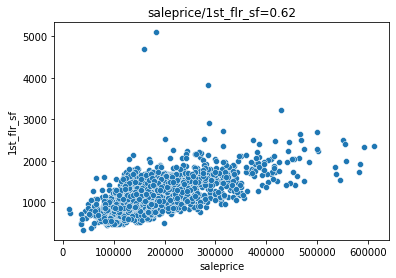

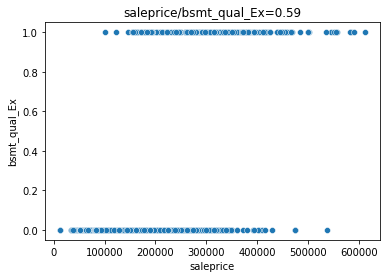

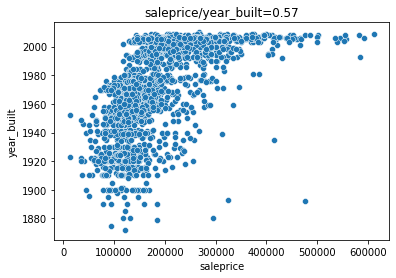

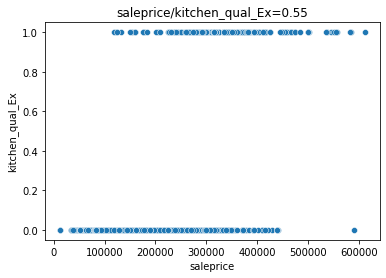

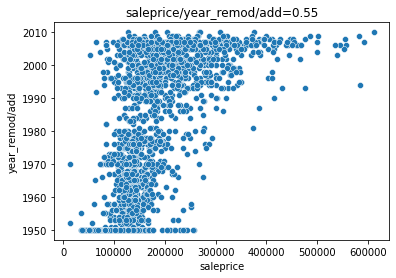

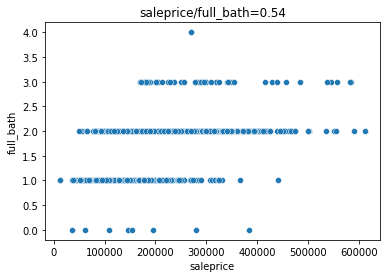

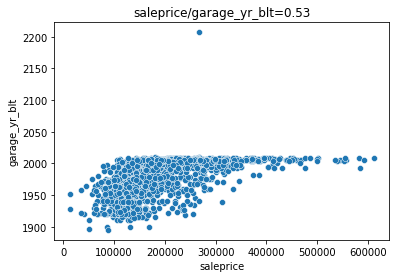

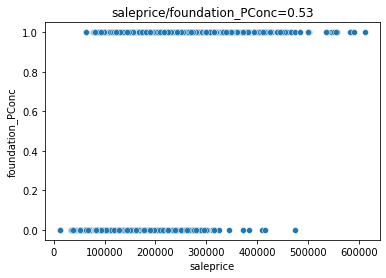

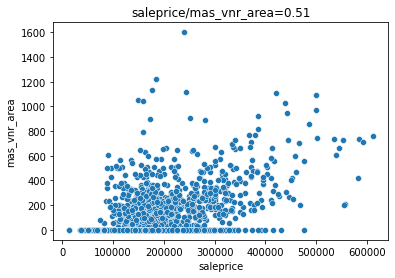

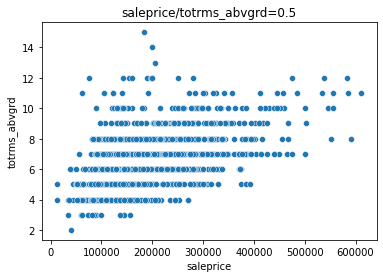

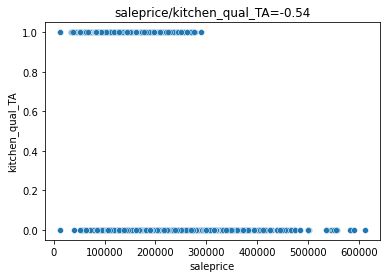

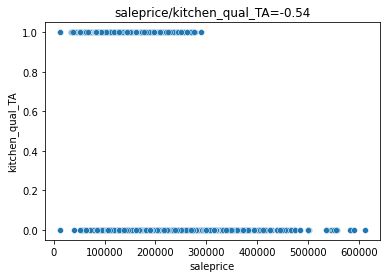

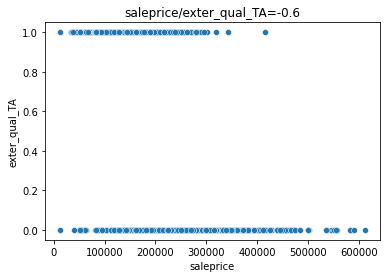

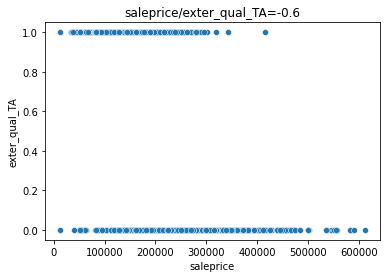

In [19]:
# graph all high and low correlations with saleprice
for i, j in saleprice_corl:
    if i[0] == 'saleprice' and i[1] != 'saleprice':
        sns.scatterplot(x=ohe_df[i[0]], y=ohe_df[i[1]])
        plt.title(f'{i[0]}/{i[1]}={round(j,2)}')
        plt.show()
    elif i[1] == 'saleprice' and i[0] != 'saleprice':
        sns.scatterplot(x=ohe_df[i[1]], y=ohe_df[i[0]])
        plt.title(f'{i[1]}/{i[0]}={round(j,2)}')
        plt.show()
        

## Positive Correlations:

### Year Built

- Year Built (Discrete): Original construction date
- SalePrice (Continuous): Sale price $$

- Year Remod/Add (Discrete): Remodel date (same as construction date if no remodeling or additions)
- SalePrice (Continuous): Sale price $$

In [20]:
max_year_blt = train_copy['year_built'].max()
min_year_blt = train_copy['year_built'].min()
mean_saleprice_year = train_copy.groupby(['year_built'])['saleprice'].mean()
mean_saleprice_year.sort_values()
max_year_blt, min_year_blt

(2010.0, 1872.0)

In [21]:
max_year_rblt = train_copy['year_remod/add'].max()
min_year_rblt = train_copy['year_remod/add'].min()
mean_saleprice_yearrm = train_copy.groupby(['year_remod/add'])['saleprice'].mean()
mean_saleprice_yearrm.sort_values()
max_year_blt, min_year_blt

(2010.0, 1872.0)

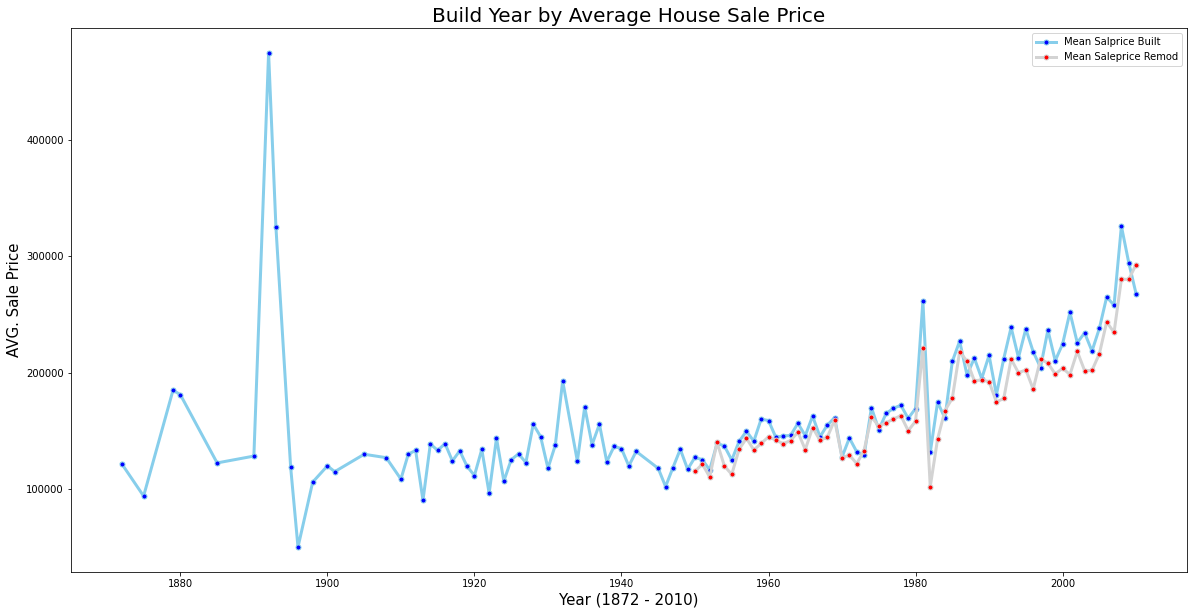

In [22]:
plt.figure(figsize=(20,10))
plt.plot(mean_saleprice_year.index, mean_saleprice_year.values, marker='o', markerfacecolor='blue', markersize=5, color='skyblue', linewidth=3, label = 'Mean Salprice Built')
plt.plot(mean_saleprice_yearrm.index, mean_saleprice_yearrm.values, marker='o', markerfacecolor='red', markersize=5, color='lightgrey', linewidth=3, label = 'Mean Saleprice Remod')
plt.title(f'Build Year by Average House Sale Price', size = 20)
plt.xlabel(f'Year ({int(min_year_blt)} - {int(max_year_blt)})', size = 15)
plt.ylabel('AVG. Sale Price', size = 15)
plt.legend()
plt.savefig('./img/mean_house_sp.jpg',bbox_inches='tight', dpi=150)
plt.show()

- Garage Yr Blt (Discrete): Year garage was built
- SalePrice (Continuous): Sale price $$

In [23]:
max_year_gblt = train_copy['garage_yr_blt'].max()
min_year_gblt = train_copy['garage_yr_blt'].min()
num_garage_blt = train_copy.groupby(['garage_yr_blt'])['garage_yr_blt'].count().sum()
num_garage_blt

2051

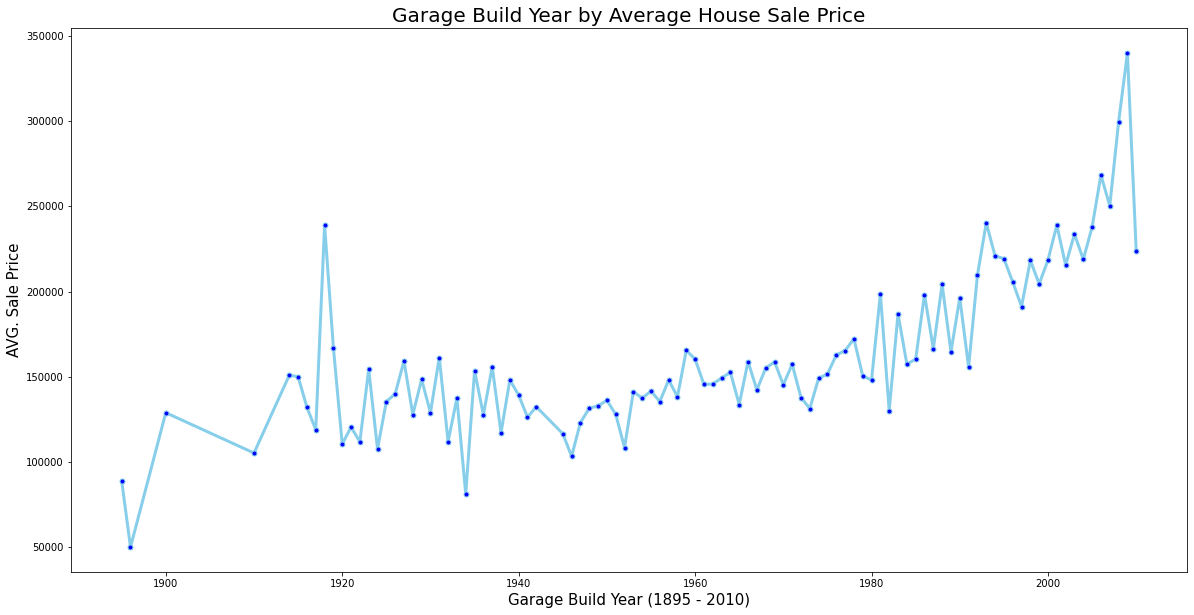

In [24]:
temp = ohe_df[ohe_df['garage_yr_blt'] <= 2010]
max_year_gblt = temp['garage_yr_blt'].max()
min_year_gblt = temp['garage_yr_blt'].min()
garage_blt_sp = temp.groupby(['garage_yr_blt'])['saleprice'].mean()
plt.figure(figsize=(20,10))
plt.plot(garage_blt_sp.index, garage_blt_sp.values, marker='o', markerfacecolor='blue', markersize=5, color='skyblue', linewidth=3, label = 'Mean Salprice Built')
plt.title(f'Garage Build Year by Average House Sale Price', size = 20)
plt.xlabel(f'Garage Build Year ({int(min_year_gblt)} - {int(max_year_gblt)})', size = 15)
plt.ylabel('AVG. Sale Price', size = 15)
plt.savefig('./img/mean_house_sp_gy.jpg',bbox_inches='tight', dpi=150)
plt.show()

### Quality

- Overall Qual (Ordinal): Rates the overall material and finish of the house
- SalePrice (Continuous): Sale price $$

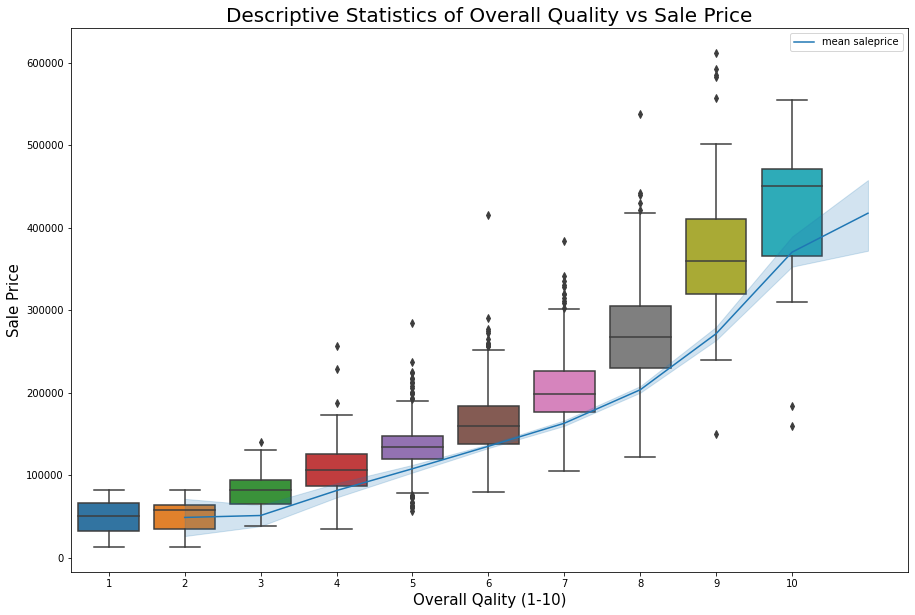

In [25]:
plt.figure(figsize=(15,10))
sns.boxplot(x=ohe_df['overall_qual'], y=ohe_df['saleprice'])
sns.lineplot(x=ohe_df['overall_qual'], y=ohe_df['saleprice'], dashes=True, label='mean saleprice')
plt.title('Descriptive Statistics of Overall Quality vs Sale Price', size = 20)
plt.xlabel('Overall Qality (1-10)', size=15)
plt.ylabel('Sale Price', size=15)
plt.savefig('./img/ds_q_sp.jpg',bbox_inches='tight', dpi=150)
plt.show()

`Positive`

- Bsmt Qual (Ordinal): Evaluates the height of the basement = Ex	Excellent (100+ inches)	
- SalePrice (Continuous): Sale price $$

- KitchenQual (Ordinal): Kitchen quality = Ex	Excellent
- SalePrice (Continuous): Sale price $$

`Negative`
- Exter Qual (Ordinal): Evaluates the quality of the material on the exterior = TA	Average/Typical
- SalePrice (Continuous): Sale price $$

- KitchenQual (Ordinal): Kitchen quality = TA	Typical/Average
- SalePrice (Continuous): Sale price $$

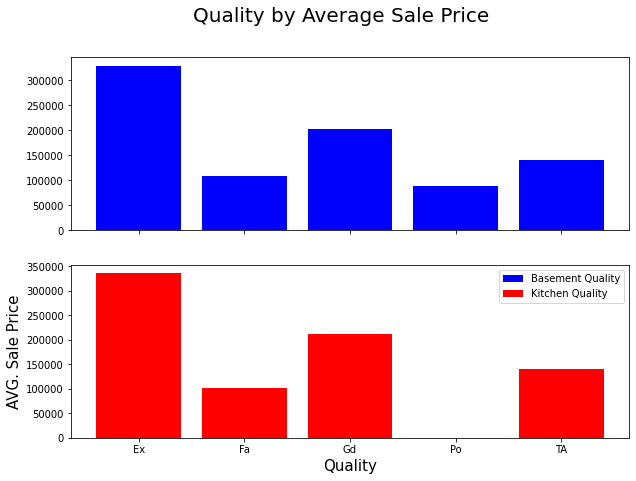

In [26]:
bsmt_q = train_copy.groupby(['bsmt_qual'])['saleprice'].mean()
k_q = train_copy.groupby(['kitchen_qual'])['saleprice'].mean()

fig, axs = plt.subplots(2, sharex=True, figsize=(10,7))
fig.suptitle('Quality by Average Sale Price', size = 20)
l1 = axs[0].bar(bsmt_q.index, bsmt_q.values, color='blue', label = 'Basement Quality')
l2 = axs[1].bar(k_q.index, k_q.values, color = 'red', label = 'Kitchen Quality')
plt.xlabel('Quality', size = 15)
plt.ylabel('AVG. Sale Price', size = 15)
plt.legend([l1, l2],['Basement Quality', 'Kitchen Quality'])
plt.savefig('./img/bkq_sp.jpg',bbox_inches='tight', dpi=150)
plt.show()

- TotRmsAbvGrd	(Discrete): Total rooms above grade (does not include bathrooms)
- SalePrice (Continuous): Sale price $$

- Full Bath (Discrete): Full bathrooms above grade
- SalePrice (Continuous): Sale price $$

In [27]:
train_copy['actual_totrms_abvgrd'] = train_copy['totrms_abvgrd'] + train_copy['full_bath']

In [28]:
rooms_abv_grd = train_copy.groupby(['actual_totrms_abvgrd'])['saleprice'].mean().sort_values()
rooms_abv_grd

actual_totrms_abvgrd
4.0      86047.000000
3.0      92150.000000
5.0     125845.355932
6.0     128649.993976
7.0     152609.504739
8.0     179348.022959
17.0    183850.000000
16.0    200000.000000
9.0     213932.698667
10.0    220466.295775
12.0    268566.075472
11.0    269821.883721
14.0    303948.812500
13.0    317183.181818
15.0    355286.600000
Name: saleprice, dtype: float64

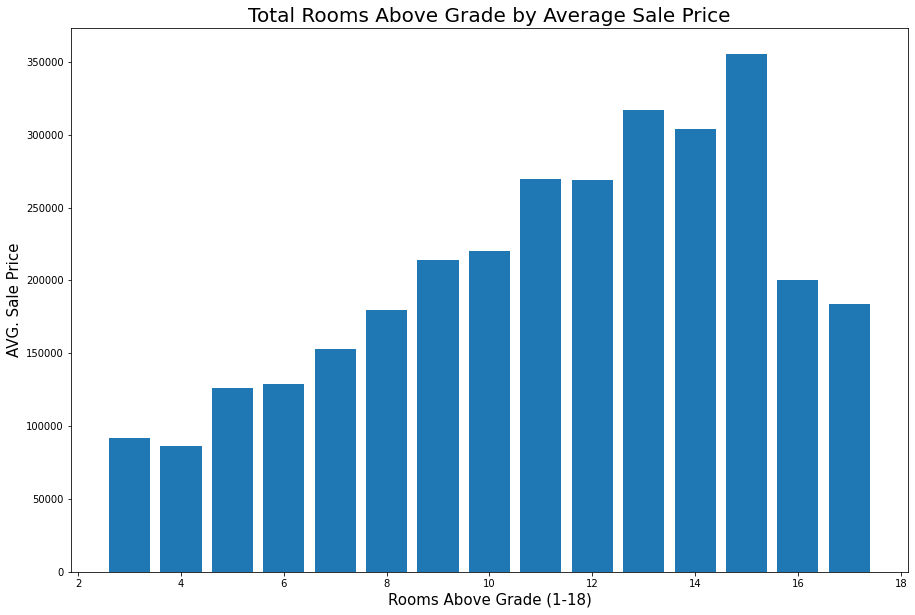

In [29]:
plt.figure(figsize=(15,10))
plt.bar(rooms_abv_grd.index, rooms_abv_grd.values)
plt.title('Total Rooms Above Grade by Average Sale Price', size = 20)
plt.xlabel('Rooms Above Grade (1-18)', size=15)
plt.ylabel('AVG. Sale Price', size=15)
plt.savefig('./img/rms_abv_grade.jpg',bbox_inches='tight', dpi=150)
plt.show()

### Area/SQ FT

- Garage Area (Continuous): Size of garage in square feet
- SalePrice (Continuous): Sale price $$

- Gr Liv Area (Continuous): Above grade (ground) living area square feet
- SalePrice (Continuous): Sale price $$

In [30]:
train_copy.columns
train_copy['g_gr_area'] = train_copy['garage_area'] + train_copy['gr_liv_area']

In [31]:
temp = train_copy[train_copy['g_gr_area'] > 0]
g_gr_area = temp.groupby(['g_gr_area'])['saleprice'].mean().sort_values()


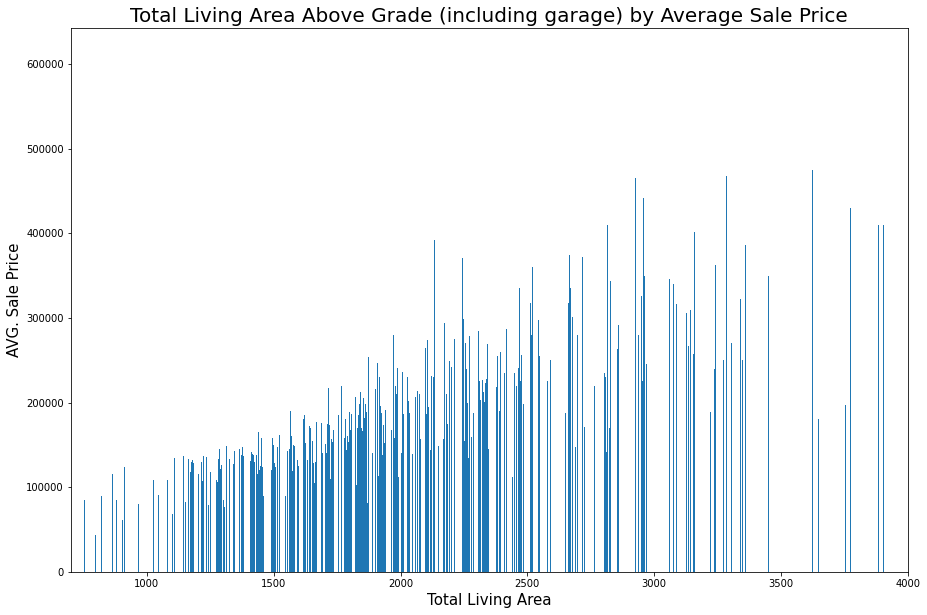

In [32]:
plt.figure(figsize=(15,10))
plt.bar(temp['g_gr_area'], temp['saleprice'])
plt.title('Total Living Area Above Grade (including garage) by Average Sale Price', size = 20)
plt.xlabel('Total Living Area', size=15)
plt.ylabel('AVG. Sale Price', size=15)
plt.xlim([700, 4000])
plt.savefig('./img/Total_Living_Area.jpg',bbox_inches='tight', dpi=150)
plt.show()

- 1st Flr SF (Continuous): First Floor square feet
- SalePrice (Continuous): Sale price $$

- Total Bsmt SF (Continuous): Total square feet of basement area
- SalePrice (Continuous): Sale price $$

In [33]:
train_copy.columns
train_copy['total_sf'] = train_copy['1st_flr_sf'] + train_copy['total_bsmt_sf']

In [34]:
total_sf = train_copy.groupby(['total_sf'])['saleprice'].mean().sort_values()

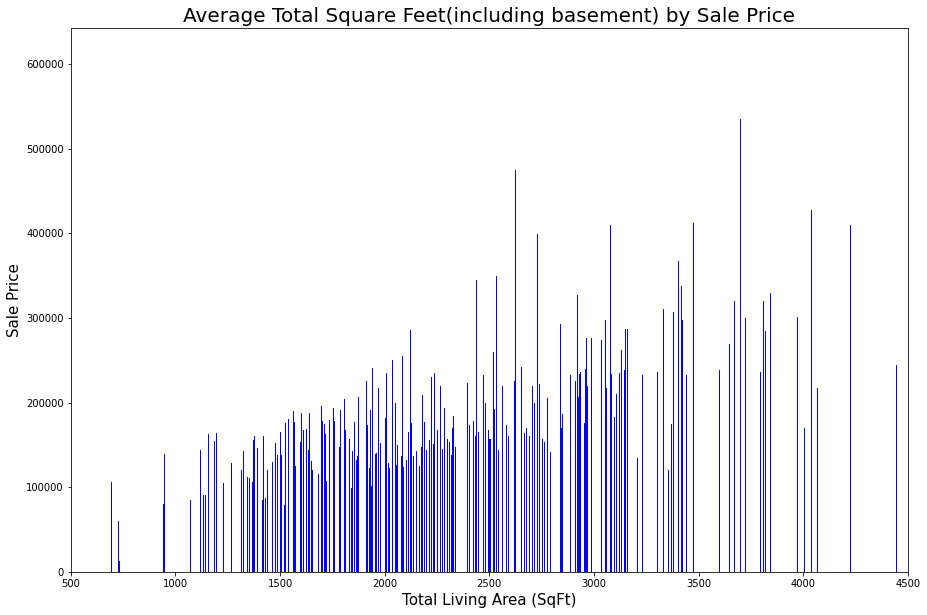

In [35]:
plt.figure(figsize=(15,10))
plt.bar(total_sf.index, total_sf.values, color='blue')
plt.title('Average Total Square Feet(including basement) by Sale Price', size = 20)
plt.xlabel('Total Living Area (SqFt)', size=15)
plt.ylabel('Sale Price', size=15)
plt.xlim([500, 4500])
plt.savefig('./img/total_sqft.jpg',bbox_inches='tight', dpi=150)
plt.show()

### Other

- Foundation (Nominal): Type of foundation = PConc	Poured Contrete	
- SalePrice (Continuous): Sale price $$

In [36]:
train_copy.columns
foundation = train_copy.groupby(['foundation'])['saleprice'].mean().sort_values()

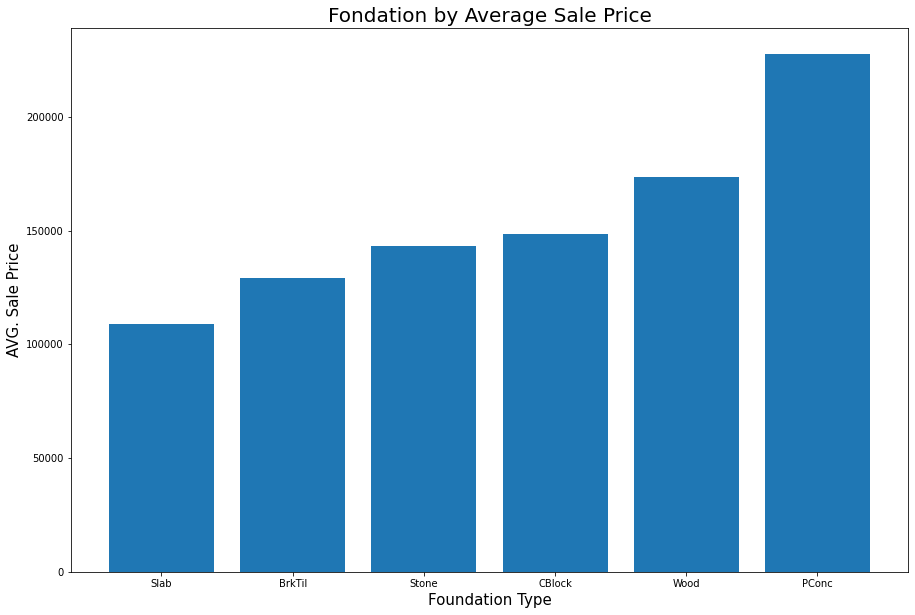

In [37]:
plt.figure(figsize=(15,10))
plt.bar(foundation.index, foundation.values)
plt.title('Fondation by Average Sale Price', size = 20)
plt.xlabel('Foundation Type', size=15)
plt.ylabel('AVG. Sale Price', size=15)
plt.savefig('./img/f_sp.jpg',bbox_inches='tight', dpi=150)
plt.show()

- Mas Vnr Area (Continuous): Masonry veneer area in square feet
- SalePrice (Continuous): Sale price $$

In [38]:
train_copy.columns
mas_vnr_area = train_copy.groupby(['mas_vnr_area'])['saleprice'].mean().sort_values()
m, b = np.polyfit(mas_vnr_area.index, mas_vnr_area.values, 1)
m, b

(197.78118364521637, 173502.09784923456)

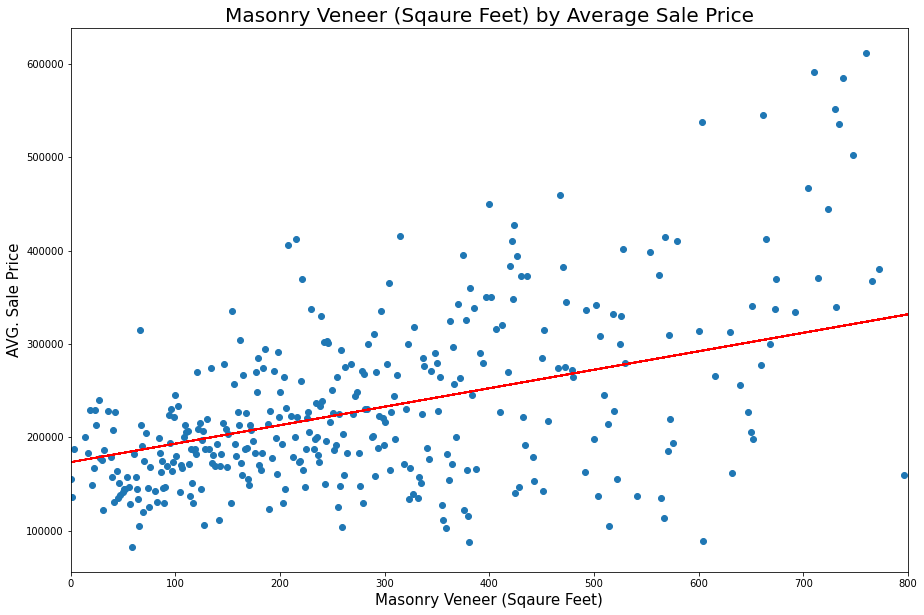

In [39]:
plt.figure(figsize=(15,10))
plt.scatter(x=mas_vnr_area.index, y=mas_vnr_area.values)
plt.plot(mas_vnr_area.index, m*mas_vnr_area.index+b, color = 'red')
plt.title('Masonry Veneer (Sqaure Feet) by Average Sale Price', size = 20)
plt.xlabel('Masonry Veneer (Sqaure Feet)', size=15)
plt.ylabel('AVG. Sale Price', size=15)
plt.xlim([0, 800])
plt.savefig('./img/m_sp.jpg',bbox_inches='tight', dpi=150)
plt.show()